In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

['T1 (us)', 'T2 (us)', 'Frequency (GHz)', 'Readout assignment error ', 'Prob meas0 prep1 ', 'Prob meas1 prep0 ', 'Readout length (ns)', 'ID error ', '√x (sx) error ', 'Pauli-X error ', 'T1 (us)', 'T2 (us)', 'Frequency (GHz)', 'Readout assignment error ', 'Prob meas0 prep1 ', 'Prob meas1 prep0 ', 'Readout length (ns)', 'ID error ', '√x (sx) error ', 'Pauli-X error ', 'gtime (ns)']
done


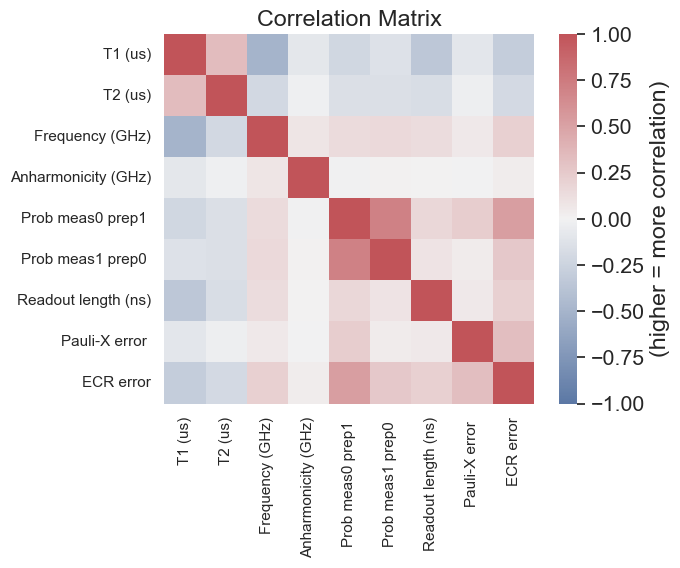

In [33]:
save_path = '/Users/home/Desktop/college/fa23/research/src/notebooks/data/127_qubit/'

input_df = pd.DataFrame()
output_df = pd.DataFrame()
gtime_df = pd.DataFrame()
heatmap_df = pd.DataFrame()

for file in os.listdir(save_path):
    tmp_input_df = pd.read_csv(os.path.join(save_path, file))
    tmp_output_df = pd.DataFrame()
    tmp_gtime_df = pd.DataFrame()

    # output dataframe: ECR error
    tmp_output_df['ECR error'] = tmp_input_df['ECR error ']
    tmp_output_df['ECR error'] = tmp_output_df['ECR error'].replace('undefined', np.nan)
    tmp_output_df['ECR error'] = tmp_output_df['ECR error'].str.split(';')
    tmp_output_df = tmp_output_df.explode('ECR error')
    tmp_output_df = tmp_output_df.dropna(subset=['ECR error'])
    tmp_output_df = tmp_output_df.reset_index(drop=True)
    tmp_flattened_output_data = tmp_output_df['ECR error'].values
    
    # need to create separate dataframe for gate time; no need to flatten yet
    tmp_gtime_df['gtime (ns)'] = tmp_input_df['Gate time (ns)']
    tmp_gtime_df['gtime (ns)'] = tmp_gtime_df['gtime (ns)'].replace('undefined', np.nan)
    tmp_gtime_df['gtime (ns)'] = tmp_gtime_df['gtime (ns)'].str.split(';')
    tmp_gtime_df = tmp_gtime_df.explode('gtime (ns)')
    tmp_gtime_df = tmp_gtime_df.dropna(subset=['gtime (ns)'])
    tmp_gtime_df = tmp_gtime_df.reset_index(drop=True)
    
    array = tmp_output_df['ECR error'].str.split('_', expand=True)
    array[1] = array[1].str.split(':').str[0]
    
    tmp_input_df = tmp_input_df.drop('ECR error ', axis=1)
    tmp_input_df = tmp_input_df.drop('Gate time (ns)', axis=1)
    
    tmp_heatmap_df = tmp_output_df
    # check if the ECR error column has a 1 after the colon; if it does, drop the row
    for index, row in tmp_heatmap_df.iterrows():
        if ':1' in row['ECR error']:
            tmp_heatmap_df = tmp_heatmap_df.drop(index)
    tmp_heatmap_df = tmp_heatmap_df.reset_index(drop=True)
    avg_ecr_error = dict()
    # if found, add the value after the colon in the string into a dictionary
    for i in range(127):
        for j in range(len(tmp_heatmap_df['ECR error'])):
            if tmp_heatmap_df['ECR error'].iloc[j].split(':')[0].split('_')[0] == str(i):
                if i not in avg_ecr_error:
                    avg_ecr_error[i] = []
                avg_ecr_error[i].append(float(tmp_heatmap_df['ECR error'].iloc[j].split(':')[1]))
            elif tmp_heatmap_df['ECR error'].iloc[j].split(':')[0].split('_')[1] == str(i):
                if i not in avg_ecr_error:
                    avg_ecr_error[i] = []
                avg_ecr_error[i].append(float(tmp_heatmap_df['ECR error'].iloc[j].split(':')[1]))
    
    # for every key, average the values and then set that as the value for the key
    for key in avg_ecr_error:
        avg_ecr_error[key] = sum(avg_ecr_error[key]) / len(avg_ecr_error[key])
        tmp_heatmap_df['ECR error'].iat[key] = avg_ecr_error[key]
         
    # combine tmp_heatmap_df with tmp_input_df; set tmp_heatmap_df as the new dataframe and tmp_heatmap_df at the end
    intermediate_df = tmp_input_df
    intermediate_df.insert(12, 'ECR error', tmp_heatmap_df['ECR error'])
    tmp_heatmap_df = intermediate_df
    
    # drop all rows that have a invalid ECR error value
    for index, row in tmp_heatmap_df.iterrows():
        if type(row['ECR error']) != float:
            tmp_heatmap_df = tmp_heatmap_df.drop(index)
    
    tmp_heatmap_df = tmp_heatmap_df.reset_index(drop=True)
    heatmap_df = pd.concat([heatmap_df, tmp_heatmap_df])
    
    # drop all error value columns
    # filter_columns = tmp_input_df.filter(like='error', axis=1)
    # tmp_input_df = tmp_input_df.drop(columns=filter_columns)
    
    tmp_formatted_ecrgate_df = pd.DataFrame()
    
    for index, row in array.iterrows():
        found_rows = pd.DataFrame()
        for value in row:
            found_rows = pd.concat([found_rows, tmp_input_df.loc[tmp_input_df['Qubit'] == int(value)]])
        found_rows = pd.concat([found_rows.iloc[0], found_rows.iloc[1]], axis=0).to_frame().T
        tmp_formatted_ecrgate_df = pd.concat([tmp_formatted_ecrgate_df, found_rows])
    
    tmp_formatted_ecrgate_df = tmp_formatted_ecrgate_df.drop('Qubit', axis=1)
    tmp_formatted_ecrgate_df = tmp_formatted_ecrgate_df.drop('ECR error', axis=1)
    tmp_output_df = pd.concat([tmp_output_df.reset_index(drop=True),tmp_formatted_ecrgate_df.reset_index(drop=True)], axis=1)
    tmp_output_df = pd.concat([tmp_output_df.reset_index(drop=True), tmp_gtime_df.reset_index(drop=True)], axis=1)

    tmp_output_df['ECR error'] = tmp_output_df['ECR error'].str.split(':').str[1]
    tmp_output_df['gtime (ns)'] = tmp_output_df['gtime (ns)'].str.split(':').str[1]
    output_df = pd.concat([output_df, tmp_output_df])
    
heatmap_df = heatmap_df.reset_index(drop=True)
heatmap_df = heatmap_df.drop('Qubit', axis=1)
heatmap_df = heatmap_df.drop(index=[870])

# for a smaller heatmap
heatmap_df = heatmap_df.drop(columns=['ID error ', '√x (sx) error ', 'Readout assignment error '])

output_df = output_df.reset_index(drop=True)
output_df = output_df.drop(index=[148,168,991,1007]) # manual dropping; didn't get around to automatically doing it
output_df = output_df.reset_index(drop=True)
output_df = output_df.astype(float)
MAX_ERR = 0.1
output_df = output_df[output_df['ECR error'] <= MAX_ERR]
for i in range(len(output_df.columns)):
    output_df.iloc[:,i] = output_df.iloc[:,i].apply(lambda x: x if x > 0.0 else None)
output_df = output_df.dropna(axis=1, how='all')
input_df = output_df
input_df = input_df.drop('ECR error', axis=1)
list_names = input_df.columns
output_df = output_df['ECR error']

feature_names = list(input_df.keys())
print(feature_names)

# matplotlib plot
# fig = plt.figure(figsize=(9,5))
# plt.matshow(input_df.corr(), fignum=fig.number)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=12)
# plt.title('Correlation Matrix', fontsize=14)
# plt.show()

# seaborn plot
f, ax = plt.subplots()
corr = heatmap_df.corr()
sns.set(font_scale=1.4)
sns.heatmap(corr,
            cmap=sns.diverging_palette(h_neg=250, h_pos=10, s=50, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            cbar_kws={'label': '(higher = more correlation)'})
ax.set_title('Correlation Matrix')

# create seaborn plot of the input variables but average only use one qubit for each ecr error by averaging all the ecr errors that the qubit shows up in

print('done')

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

X = np.array(input_df)
y = np.array(output_df)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
X.astype(float)

print("Original features: %s\n" % str(list(enumerate(feature_names))))
print(X.shape)
X -= np.mean(X, axis=0)
Xstd = np.std(X, axis=0)
print("Standard Deviations: %s\n" %str(list(zip(feature_names, Xstd))))
x_inds_bad = [i for i in range(len(feature_names)) if Xstd[i] <= 0.00000001]
print("Bad names: %s\n" % str([feature_names[i] for i in x_inds_bad]))
feature_names = [feature_names[i] for i in range(len(feature_names)) if i not in x_inds_bad]
X = np.delete(X, x_inds_bad, axis=1)
X /= np.std(X, axis=0)
print(X.shape)

print("New features: %s\n" % str(list(zip(feature_names, X[0]))))

y -= np.mean(y)
y /= np.std(y)

y_mean = np.mean(y)
baseline_mse = mean_squared_error(np.ones(len(y), dtype=np.double)*y_mean, y)
print("Average MSE of average: %f" % baseline_mse)

print('done')

{'Alpha': 0.11, 'Avg_MSE': 0.9002116426996638, 'Avg_R2': 0.10493547412992454}
[-0.         -0.0259184   0.          0.          0.          0.
  0.          0.          0.          0.         -0.02309176 -0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.00620798  0.0062154
  0.00620995 -0.         -0.01094183 -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.01438874 -0.         -0.         -0.         -0.02306652
 -0.         -0.         -0.         -0.         -0.         -0.00787028
 -0.          0.         -0.         -0.02306629 -0.         -0.
 -0.         -0.01816705  0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.04116013  0.          0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.  

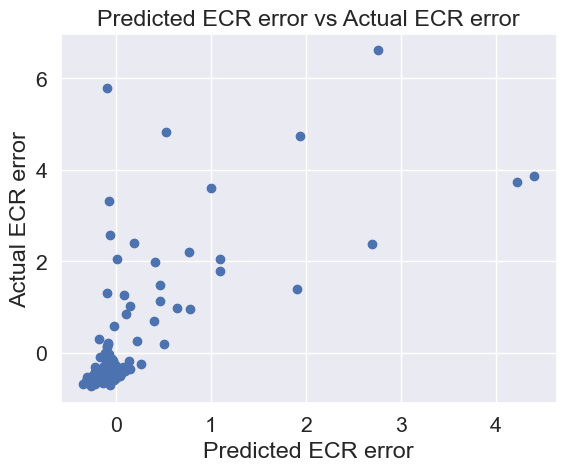

In [34]:
l1_ratio = 0.5
results = []
coeff = []

for i in range(1):
    alpha = 0.11
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    mse_scores = []
    r2_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        r2_scores.append(r2)
        
    
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)

    print(str({'Alpha': alpha, 'Avg_MSE': avg_mse, 'Avg_R2': avg_r2}))
    results.append({'Alpha': alpha, 'Avg_MSE': avg_mse, 'Avg_R2': avg_r2})
    print(model.coef_)
    coeff.append(model.coef_)
    print("Non-zero coeffs: %s" % (str([feature_names[i] for i in range(len(feature_names)) if (model.coef_[i] != 0)]),))
    print()

results_df = pd.DataFrame(results)
# results_coeff_df = pd.DataFrame(coeff, columns=list_names)
results_coeff_df = pd.DataFrame(coeff)

# plot predicted ECR error vs actual ECR error
plt.rcParams.update({'font.size': 22})
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted ECR error')
plt.ylabel('Actual ECR error')
plt.title('Predicted ECR error vs Actual ECR error')
plt.show()


results_df.to_csv('qubit_regression3.csv', index=True)
results_coeff_df.to_csv('coefficients3.csv', index=True)